# MinMaxScaler transforms features to lie within a specified range, normalizing the data and improving computational performance.

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'  # 必须在导入keras前设置
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.layers import Input, Dense, Dropout, LSTM

In [2]:
df = pd.read_csv("Gold_Price_Cleaned.csv", index_col = 0)
df.head()

,Date,Close,High,Low,Open
0,2013-01-02,163.169998,164.139999,163.139999,163.490005
1,2013-01-03,161.199997,162.880005,160.830002,162.479996
2,2013-01-04,160.440002,160.630005,158.889999,159.520004
3,2013-01-07,159.429993,159.960007,159.149994,159.360001
4,2013-01-08,160.559998,160.990005,160.009995,160.460007


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Close,High,Low,Open
0,2013-01-02,163.169998,164.139999,163.139999,163.490005
1,2013-01-03,161.199997,162.880005,160.830002,162.479996
2,2013-01-04,160.440002,160.630005,158.889999,159.520004
3,2013-01-07,159.429993,159.960007,159.149994,159.360001
4,2013-01-08,160.559998,160.990005,160.009995,160.460007
...,...,...,...,...,...
2513,2022-12-23,167.259995,167.800003,166.660004,166.880005
2514,2022-12-27,168.669998,170.610001,167.800003,167.889999
2515,2022-12-28,167.910004,168.339996,167.100006,168.050003
2516,2022-12-29,168.850006,169.350006,168.520004,168.539993


In [4]:
scaler = MinMaxScaler()
scaler.fit(df.Close.values.reshape(-1,1))

MinMaxScaler()

- **sklearn 的 MinMaxScaler.fit() 要求输入是二维的（形状为 (n_samples, n_features)）**

- **df.Close.values 返回的是一维数组，形状像 (500,)。如果直接传给 fit() 会报错或异常。**

**reshape(-1,1) 的意思：**
- -1：让 NumPy 自动推断这一维的大小（这里就是 500）。

- 1：表示“每一行 1 个特征/列” —— 所以最终变成 (500,1)。

**MinMaxScaler 的行为**
- scaler.fit(close_col) 会记录最小值 data_min_ 与最大值 data_max_，默认把数值缩放到区间 [0,1]：
scaled = (x - data_min) / (data_max - data_min)

- 由运行结果可看到 data_min_ / data_max_，以及一些 scaled 示例值（上面有打印）。

In [5]:
window_size = 60

**window_size 与 LSTM 序列构造（为什么得到 (440,60)）**
- 如果原始时间序列长 N（示例 N=500），用 window_size=60 则能产生 N - window_size 个训练样本（因为每个样本需要前 60 个时刻作为输入去预测第 61 个）。

- samples = N - window_size = 500 - 60 = 440

In [6]:
test_size = df[df.Date.dt.year == 2022].shape[0]
test_size

251

**test_size = df[df.Date.dt.year == 2022].shape[0] 是统计 2022 年的行数（天数）**

df.Date.dt.year == 2022

df.Date → 取出日期这一列。

.dt.year → 提取日期里的年份。

== 2022 → 判断是否等于 2022 年。
👉 结果是一个 布尔Series，比如：

df[df.Date.dt.year == 2022]

用布尔条件筛选出 2022 年的数据行。
👉 得到一个新的 DataFrame，只包含 2022 年的黄金价格记录。

.shape

DataFrame 的形状 → 返回一个 元组 (行数, 列数)。

举例：如果 2022 年有 250 条交易日数据，每条有 2 列（Date 和 Close），那么结果是 (250, 2)。

.shape[0]

shape[0] → 取出 行数，也就是数据条数。

在机器学习里，我们通常关心 样本数量（行数），而不是列数。

所以这里 test_size 就等于 2022 年的数据条数。

In [7]:
train_data = df.Close[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))
train_data

array([[0.67105684],
       [0.64996249],
       [0.64182464],
       ...,
       [0.72909302],
       [0.74204951],
       [0.75447058]])

**scaler.transform(...) → 把价格缩放到 0 和 1 之间。**

**这里的 train_data 不再是一维，而是 二维数组，形状是 (样本数, 1)。**

In [8]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i,0])

X_train → 特征（输入序列）。

y_train → 标签（预测目标）。

- window_size = 60
→ 我们用 前 60 天的数据 来预测 第 61 天的价格。

- train_data[i-60:i, 0]
→ 从 i-60 到 i-1 的 60 天价格，作为一条训练样本。

例如：i=60 时，取的是 [0:60] 的数据（前 60 天）。

- train_data[i,0]
→ 第 i 天的价格，作为预测目标。

例如：i=60 时，目标是第 60 天的价格（即第 61 天）。---**实际取的就是i**

2. 为什么有 ,0

当你写 train_data[i-60:i, 0] 时：

i-60:i → 取 60 行（连续 60 天的数据）。---**实际取的是序列0到序列i-1**

,0 → 取第 0 列（就是唯一的那一列“收盘价”）。

👉 **结果是一个长度为 60 的数组，形状 (60,)。**

3. 当你写 train_data[i, 0] 时：

i → 取第 i 行（某一天）。

,0 → 取第 0 列（收盘价）。

👉 **结果就是一个 单独的数字，比如 0.82。**

In [9]:
test_data = df.Close[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))
train_data

array([[0.67105684],
       [0.64996249],
       [0.64182464],
       ...,
       [0.72909302],
       [0.74204951],
       [0.75447058]])

[-test_size-60:] → 从 倒数第 (test_size+60) 行开始，一直取到最后。

如果 test_size = 250（2022 年的 250 天数据），那么就是从 最后 310 行 开始取。

也就是说，测试集里不光有 2022 年的数据，还额外往前取了 60 天。

👉 为什么要多取 60 天？
因为做预测的时候，第一天（2022-01-01）的预测需要前 60 天的历史数据。
如果你只取 2022 年的 250 天，就会发现 第一天没法预测，因为没有“过去 60 天”。

所以这一步的作用就是：

给测试集“带上”额外的 60 天历史数据，保证预测时有足够的输入。

In [10]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i,0])

In [11]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

为什么要 np.array？

之前我们构造 X_train、y_train 的时候，是用 列表 list 存的：

然后在 for 循环里一条条 .append() 加进去。

列表可以存东西，但它不是专门为数值运算设计的。

**LSTM 模型（Keras/TensorFlow）需要的是 numpy 数组 或 张量。**

所以这里统一把 list → numpy.array，方便后续送进模型。

In [12]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_train = np.reshape(y_train, (-1,1))
y_test = np.reshape(y_test, (-1,1))

1. (1) 原始形状

经过前面步骤，X_train 是二维的：\
X_train.shape = (样本数, 60)


2. reshape 之后
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


X_train.shape[0] → 样本数

X_train.shape[1] → 时间步（60）

1 → 特征数（这里只有“收盘价”1个特征）

3. 👉 reshape 之后：\
X_train.shape = (样本数, 60, 1)


4. 再看 y_train / y_test
(1) 原始形状

前面得到的 y_train、y_test 是一维数组：\
y_train.shape = (样本数,)


5. reshape 之后\
   y_train = np.reshape(y_train, (-1,1))\
-1 → 自动算出行数（也就是样本数）。

1 → 每个样本只有 1 个目标值。

In [13]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (2207, 60, 1)
y_train shape:  (2207, 1)
X_test shape:  (251, 60, 1)
y_test shape:  (251, 1)


In [14]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences = True)(input1)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences = True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation = 'softmax')(x)

    dnn_output = Dense(1)(x)

    model = Model(inputs = input1, outputs = [dnn_output])
    model.compile(loss = 'mean_squared_error', optimizer = 'Nadam')
    model.summary()

    return model

一、input 输入层

你的数据形状是 (window_size, 1)，

window_size：时间窗口大小（比如你用过去 60 天的数据来预测第 61 天）。

1：因为每一天只有一个特征 —— 黄金价格。

可以想象：模型的“眼睛”一次要看 **过去 60 天的黄金价格曲线。**

二、    x = LSTM(units = 64, return_sequences = True)(input1)
第一层 LSTM

units=64：有 64 个记忆细胞（小脑袋），用来记住时间序列的模式。

return_sequences=True：说明这一层会把 **每一天的记忆都传下去**，而不是只给最后一天。

可以想象：这是一个“60 天的黄金日记”，每一天的总结都传给下一层。

三、    x = Dropout(0.2)(x)\
Dropout

随机丢掉 20% 的神经元，防止过拟合。

就像课堂点名时，随机请一部分人闭嘴不发言，避免某几个学生（神经元）太“独裁”。

四、    x = LSTM(units = 64, return_sequences = True)(x)
    x = Dropout(0.2)(x)

第二层 LSTM

继续处理时间序列，还是把每天的输出都保留。

可以理解为：在第一本“黄金日记”之上，又写了一本更深入的“分析日记”。


五、
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)

第三层 LSTM

这次没有 return_sequences=True，说明 **只取最后一天的记忆。**

就像看了 60 天的日记后，最后做一个最终总结。

六、    x = Dense(32, activation = 'softmax')(x)

**全连接层（Dense）**

32 个神经元，softmax 激活。

这一层有点奇怪 🤔：因为预测黄金价格通常是 回归问题（预测具体数值），一般不会用 softmax（它更适合分类）。

这里应该用 relu 或者 tanh 更合理。

七、    dnn_output = Dense(1)(x)

输出层

只有 1 个神经元，输出一个数值（预测的黄金价格）。

没有激活函数，表示输出可以是任意实数。

八、    model = Model(inputs = input1, outputs = [dnn_output])
    model.sompile(loss = 'mean_squared_error', optimizer = 'Nadam')

⚠️ 这里有个小错误：

model.sompile → 应该是 model.compile（拼写错了）。
model.complie:\
model.compile 的作用

在 Keras / TensorFlow 里，**compile 就是“编译模型”：**
它告诉模型要用什么 **优化器、什么 损失函数，以及要监控哪些 指标**。

损失函数：mean_squared_error（均方误差），常用于回归。

优化器：Nadam，是一种改进版的 Adam，适合时间序列。

九、    model.summary()
    return model

打印模型结构，方便你确认。

In [15]:
model = define_model()
history= model.fit(X_train, y_train, epochs = 150, batch_size = 32, validation_split = 0.1, verbose = 1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - loss: 0.0443 - val_loss: 0.0775
Epoch 2/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0116 - val_loss: 0.0263
Epoch 3/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0061 - val_loss: 0.0166
Epoch 4/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 5/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 6/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0021 - val_loss: 0.0043
Epoch 7/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0020 - val_loss: 0.0062
Epoch 8/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0016 - val_loss: 0.0053
Epoch 9/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0014 - val_loss: 0.0075
Epoch 10/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 11/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 12/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/ste

一、model = define_model()

这里调用你之前写的 define_model()，返回的是一个编译好的 LSTM 模型。

二、model.fit(...) —— 开始训练
(1) X_train, y_train

输入数据 X_train：形状大概是 (样本数, 60, 1)，即每个样本有 60 天收盘价作为输入。

目标值 y_train：形状大概是 (样本数, 1)，对应第 61 天的价格。

就好比你给模型看了 60 天的黄金走势，让它猜第 61 天价格。

(2) epochs = 150

一个 epoch = 模型完整看一遍训练集。

设置成 150，意思是要看 150 遍。

比喻：就像你反复背书，背一遍不够牢，要背很多遍才记住。

(3) batch_size = 32

一次更新权重时，用 32 个样本。

如果训练集有 3200 个样本：

1 个 epoch = 3200 / 32 = 100 次参数更新。

好处：比“全量更新”更高效，也比“单样本更新”更稳定。

比喻：不是一口气吃完所有饭，而是分 32 口慢慢吃。

(4) validation_split = 0.1

从训练数据里拿出 10% 作为验证集（不用来训练，只用来检查效果）。

好处：你能看到模型是不是 过拟合（在训练集表现很好，但验证集表现很差）。

(5) verbose = 1

控制训练过程的输出：

0 = 静默模式（不显示）

1 = 每个 epoch 显示一行日志（最常用）

2 = 每个 epoch 显示一条进度条

✅ 总结一句话：
这一段代码就是 **把训练数据喂给 LSTM 模型，重复 150 遍，每次分 32 个样本喂，顺便留 10% 数据用来监考，最后把学习曲线保存到 history 里。**

In [16]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0039
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step


一、model.evaluate(X_test, y_test)

👉 作用：用测试集来检查模型的表现。

X_test：测试集输入（形状 (样本数, 60, 1)）

y_test：测试集真实标签（形状 (样本数, 1)）

二、
返回值 result：

因为你在 compile 时只指定了一个 loss='mse'，所以 result 就是 均方误差 (MSE)。

如果你还加了 metrics=['mae']，那 result 会是一个数组，比如 [mse, mae]。

三、📌 可以理解成：

“我让模型在从没见过的数据上考试，返回它考得多差。”

四、y_pred = model.predict(X_test)

👉 作用：让模型真正做预测。

输入 X_test（测试集的特征）

输出 y_pred（模型预测的结果，形状 (样本数, 1)）

In [17]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

一、👉 MAPE（平均绝对百分比误差）公式：
📌 直观解释：

先算每次预测的“百分比误差”，比如真实 2000，预测 1980，误差是 20，百分比误差是 20/2000=1%

对所有测试数据取平均 → 就得到 MAPE。

二、Accuracy = 1 - MAPE\
因为 MAPE 是“误差”，越小越好，所以很多人会转成“准确率”方便理解：

In [18]:
print('Test Loss:', result)
print('Test MAPE:', MAPE)
print('Test Accuracy:', Accuracy)

Test Loss: 0.003914875444024801
Test MAPE: 0.08384964098859313
Test Accuracy: 0.9161503590114068


MSE 就像是：把所有飞镖离靶心的距离²，加起来取平均。\
MSE 越小 → 模型预测越准

MSE 越大 → 模型预测越差

MSE:\
拿预测值和真实值的差 → 
𝑦
𝑖
−
𝑦
^
𝑖
y
i
	​

−
y
^
	​

i
	​


平方（保证都是正数，不会互相抵消）

对所有样本求平均

一、 test loss \
MSE: ≈0.0039\
因为你的 loss 是 MSE（均方误差），这里 0.0039 的意思是：\
注意：这个值是基于 归一化后的价格 算的（因为之前用了 MinMaxScaler 把价格缩放到 [0,1]）。\

所以 0.0039 在 [0,1] 的范围里，其实是一个挺小的误差。\
结论：模型在归一化空间里学得还不错。

In [19]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

一、把归一化后的数据“还原”回真实价格

二、
y_test_true = scaler.inverse_transform(y_test)

y_test 是归一化后的真实值（比如 0.72）。

inverse_transform 就是 把缩放反过来。

得到 y_test_true，就是原始的黄金价格（比如 2000 美元）。

三、
y_test_pred = scaler.inverse_transform(y_pred)

y_pred 是归一化后的预测值（比如 0.71）。

同样用 inverse_transform 转换，得到预测的真实价格（比如 1985 美元）。

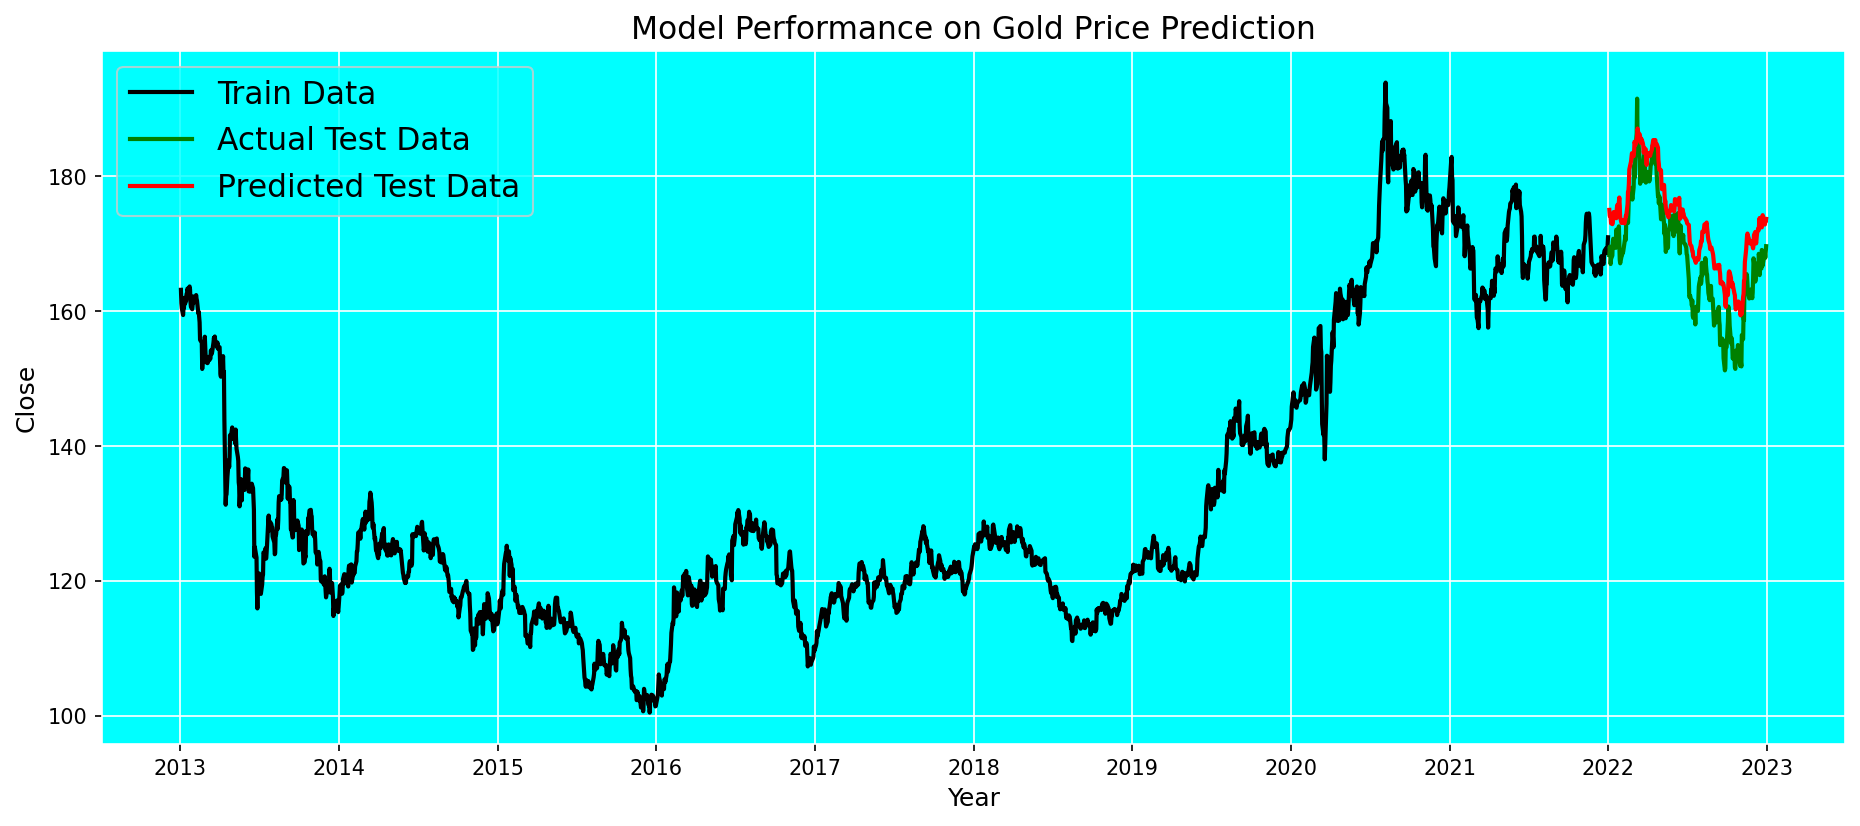

In [22]:
plt.figure(figsize=(15,6), dpi=150)
plt.rcParams['axes.facecolor'] = 'cyan'
plt.rc('axes', edgecolor = 'white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color = 'black' ,lw =2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color = 'green' ,lw =2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color = 'red' ,lw =2)
plt.title('Model Performance on Gold Price Prediction', fontsize = 15)
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Close', fontsize = 12)
plt.legend(['Train Data', 'Actual Test Data', 'Predicted Test Data'], loc = 'upper left', prop = {'size' : 15})

plt.grid(color = 'white')
plt.show()